In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from hampel import hampel
import time
from IPython.display import clear_output
import matplotlib.dates as mdates


In [67]:
df = pd.read_csv('medidas_04-05-2021/quarterly_measurements_CPD1.csv')

In [68]:
df['total_consumption'] = df['consumption_peak_time'] + df['consumption_off_peak_time'] + df['generated_energy_off_peak_time'] + df['generated_energy_peak_time']

In [69]:
df['collection_date'] = pd.to_datetime(df['collection_date'], format='%Y-%m-%d %H:%M:%S')


In [70]:
df = df.sort_values('collection_date')

In [71]:
df.reset_index(drop=True, inplace=True)

In [72]:
no_outliers_consumption = hampel(df['total_consumption'], window_size=16, n=2, imputation=True)

In [73]:
df['no_outliers_consumption'] = no_outliers_consumption

In [74]:
X = df['no_outliers_consumption'].values
size = int(len(X) * 0.7)
train, test = X[:size], X[size:]
history = [x for x in train]
predictions = list()
a = 0
b = len(train)

time_each_loop = []
# walk-forward validation
for t in range(len(test)):
    start = time.time()
    model = ARIMA(history[a:b], order=(3,0,0))
    model_fit = model.fit(method='innovations_mle')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    end = time.time()
    time_each_loop.append(end-start)
    a += 1
    b += 1
    
    print('%d: predicted=%f, expected=%f' % (t, yhat, obs))
    clear_output(wait=True)

5812: predicted=5638.807895, expected=5632.681885


In [75]:
sum(time_each_loop)/len(time_each_loop)

1.817971113235471

Test RMSE: 112.201


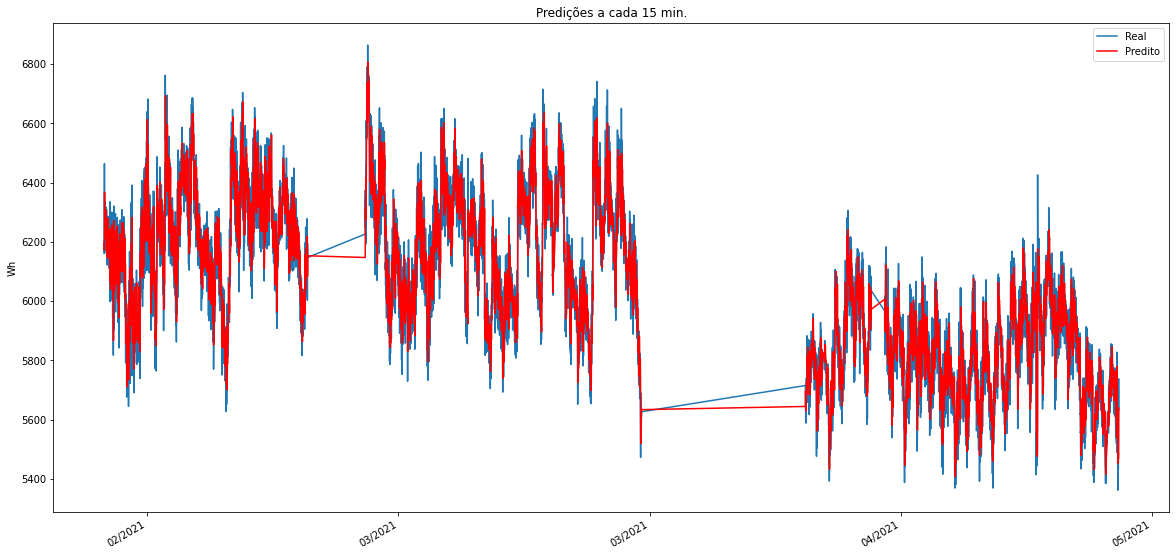

In [101]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gcf().autofmt_xdate()

plt.title('Predições a cada 15 min.')
plt.plot(df[size:].collection_date, test, label='Real')
plt.plot(df[size:].collection_date, predictions, color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()

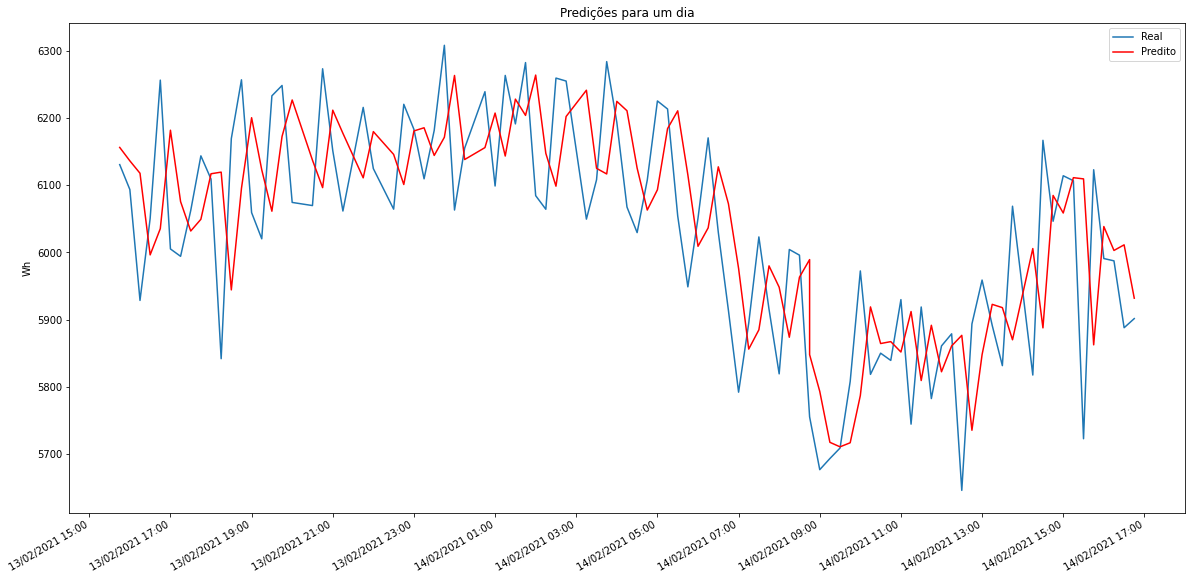

In [102]:

plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.gcf().autofmt_xdate()
plt.title('Predições para um dia')

plt.plot(df[size + 96:size+96+96].collection_date, test[96:96 + 96], label='Real')
plt.plot(df[size + 96:size+96+96].collection_date, predictions[96:96 + 96], color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()